# NIST Sand Dataset - Image and Mask Visualization

This notebook loads and visualizes image-mask pairs from all facilities in the sand_data dataset.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

## 1. Dataset Structure Overview

In [2]:
# Define base directory
base_dir = './sand_data'

# Get all facilities
facilities = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])

print("Dataset Overview:")
print("=" * 60)

dataset_info = {}
for facility in facilities:
    images_dir = os.path.join(base_dir, facility, 'images')
    masks_dir = os.path.join(base_dir, facility, 'masks')
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.tif', '.tiff'))])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.tif', '.tiff'))])
    
    dataset_info[facility] = {
        'images': image_files,
        'masks': mask_files,
        'images_dir': images_dir,
        'masks_dir': masks_dir
    }
    
    print(f"\n{facility}:")
    print(f"  Images: {len(image_files)}")
    print(f"  Masks: {len(mask_files)}")
    print(f"  Sample image: {image_files[0] if image_files else 'None'}")
    print(f"  Sample mask: {mask_files[0] if mask_files else 'None'}")

Dataset Overview:

2-bm-aps:
  Images: 4
  Masks: 4
  Sample image: sand1_recon_01212.tiff
  Sample mask: Mask_sand1_recon_01212.tiff

diad-diomand:
  Images: 5
  Masks: 5
  Sample image: Savu_k11-38727_full_fd_vo_AST_tiff_00000.tif
  Sample mask: mask_Savu_k11-38727_full_fd_vo_AST_tiff_00000.tif

emsl-pnnl:
  Images: 3
  Masks: 3
  Sample image: NIST std A 100-325 fast_0949.tif
  Sample mask: mask_NIST std A 100-325 fast_0949.tif

hex-nsls:
  Images: 11
  Masks: 11
  Sample image: HEX_scan_00220_00000.tif
  Sample mask: mask_HEX_scan_00220_00000.tif

microct-als:
  Images: 12
  Masks: 12
  Sample image: 20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.tif
  Sample mask: mask_20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.tif


## 2. Function to Load Image-Mask Pairs

In [3]:
def load_image_mask_pair(facility, index=0):
    """
    Load an image-mask pair from a specific facility.
    
    Parameters:
    -----------
    facility : str
        Name of the facility (e.g., '2-bm-aps', 'microct-als')
    index : int
        Index of the image-mask pair to load (default: 0)
    
    Returns:
    --------
    image : numpy array
        The loaded image
    mask : numpy array
        The corresponding mask
    image_name : str
        Name of the image file
    """
    info = dataset_info[facility]
    
    if index >= len(info['images']):
        raise ValueError(f"Index {index} out of range. Facility {facility} has {len(info['images'])} images.")
    
    # Get file names
    image_name = info['images'][index]
    
    # For mask, need to add 'mask_' or 'Mask_' prefix
    mask_name = None
    for mask_file in info['masks']:
        # Check if mask corresponds to image (remove mask_ or Mask_ prefix)
        if mask_file.startswith('mask_'):
            if mask_file[5:] == image_name:
                mask_name = mask_file
                break
        elif mask_file.startswith('Mask_'):
            if mask_file[5:] == image_name:
                mask_name = mask_file
                break
    
    if mask_name is None:
        raise ValueError(f"No corresponding mask found for image: {image_name}")
    
    # Load images
    image_path = os.path.join(info['images_dir'], image_name)
    mask_path = os.path.join(info['masks_dir'], mask_name)
    
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    
    return image, mask, image_name


def visualize_pair(facility, index=0, figsize=(15, 5)):
    """
    Visualize an image-mask pair.
    
    Parameters:
    -----------
    facility : str
        Name of the facility
    index : int
        Index of the pair to visualize
    figsize : tuple
        Figure size (width, height)
    """
    image, mask, image_name = load_image_mask_pair(facility, index)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Image\n{image_name}', fontsize=10)
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f'Mask\nUnique values: {np.unique(mask)}', fontsize=10)
    axes[1].axis('off')
    
    # Overlay
    overlay = image.copy()
    if len(overlay.shape) == 2:  # If grayscale, convert to RGB for overlay
        overlay = np.stack([overlay, overlay, overlay], axis=-1)
    
    # Normalize overlay to 0-1 if needed
    if overlay.max() > 1:
        overlay = overlay / overlay.max()
    
    # Create colored mask overlay (red)
    mask_colored = np.zeros_like(overlay)
    mask_colored[:, :, 0] = mask > 0  # Red channel
    
    # Blend
    alpha = 0.4
    blended = overlay * (1 - alpha * (mask > 0)[:, :, None]) + mask_colored * alpha
    
    axes[2].imshow(blended)
    axes[2].set_title('Overlay (mask in red)', fontsize=10)
    axes[2].axis('off')
    
    plt.suptitle(f'Facility: {facility} | Index: {index}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nImage Statistics:")
    print(f"  Shape: {image.shape}")
    print(f"  Dtype: {image.dtype}")
    print(f"  Range: [{image.min()}, {image.max()}]")
    print(f"  Mean: {image.mean():.2f}, Std: {image.std():.2f}")
    
    print(f"\nMask Statistics:")
    print(f"  Shape: {mask.shape}")
    print(f"  Dtype: {mask.dtype}")
    print(f"  Unique values: {np.unique(mask)}")
    print(f"  Mask coverage: {(mask > 0).sum() / mask.size * 100:.2f}%")

## 3. Visualize Sample from Each Facility


Facility: 2-bm-aps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.942217713803984e-05..0.40018151815165764].


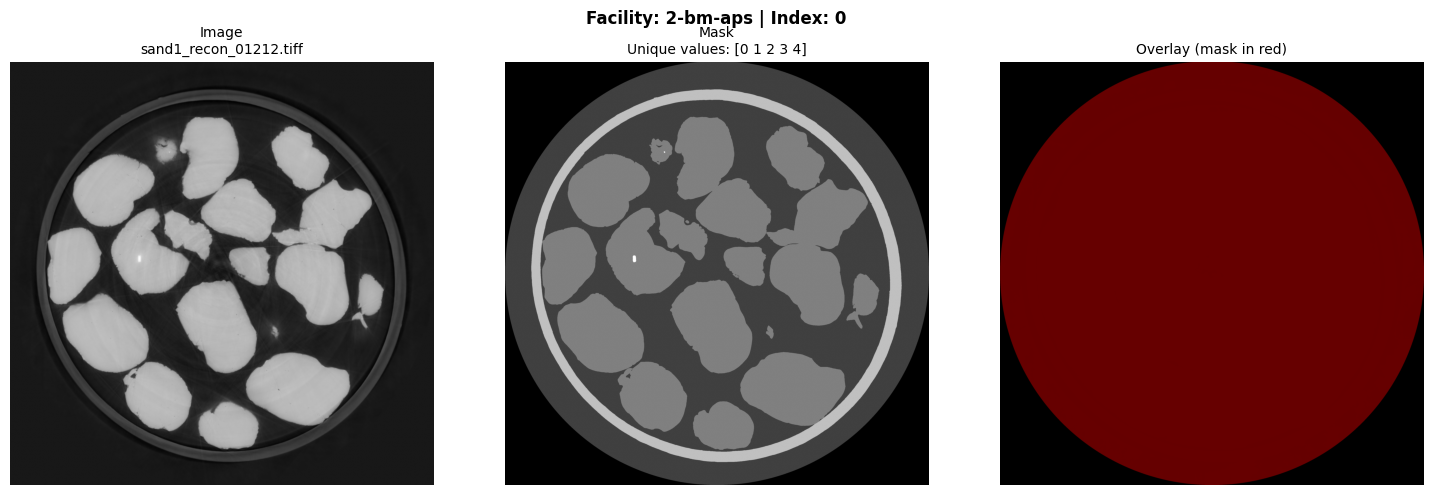


Image Statistics:
  Shape: (3232, 3232)
  Dtype: float32
  Range: [-3.2370295230066404e-05, 0.00030252031865529716]
  Mean: 0.00, Std: 0.00

Mask Statistics:
  Shape: (3232, 3232)
  Dtype: int32
  Unique values: [0 1 2 3 4]
  Mask coverage: 78.54%

Facility: diad-diomand


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0007867035688832402..0.40087281898595395].


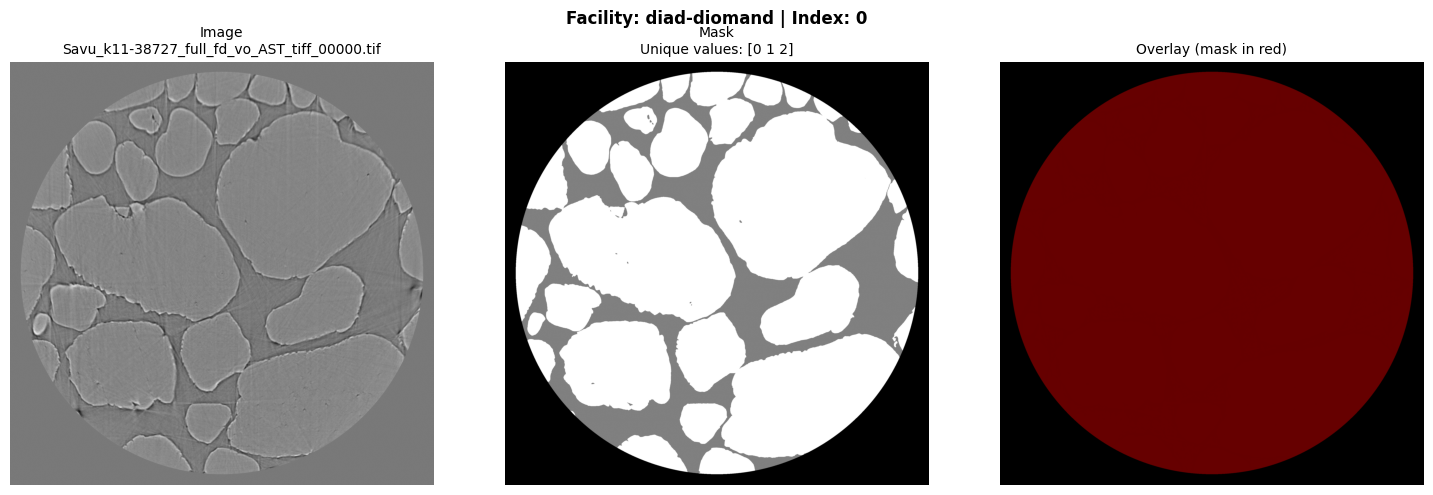


Image Statistics:
  Shape: (2560, 2560)
  Dtype: float32
  Range: [-0.0013111726148054004, 0.0014546883758157492]
  Mean: 0.00, Std: 0.00

Mask Statistics:
  Shape: (2560, 2560)
  Dtype: int32
  Unique values: [0 1 2]
  Mask coverage: 70.77%

Facility: emsl-pnnl


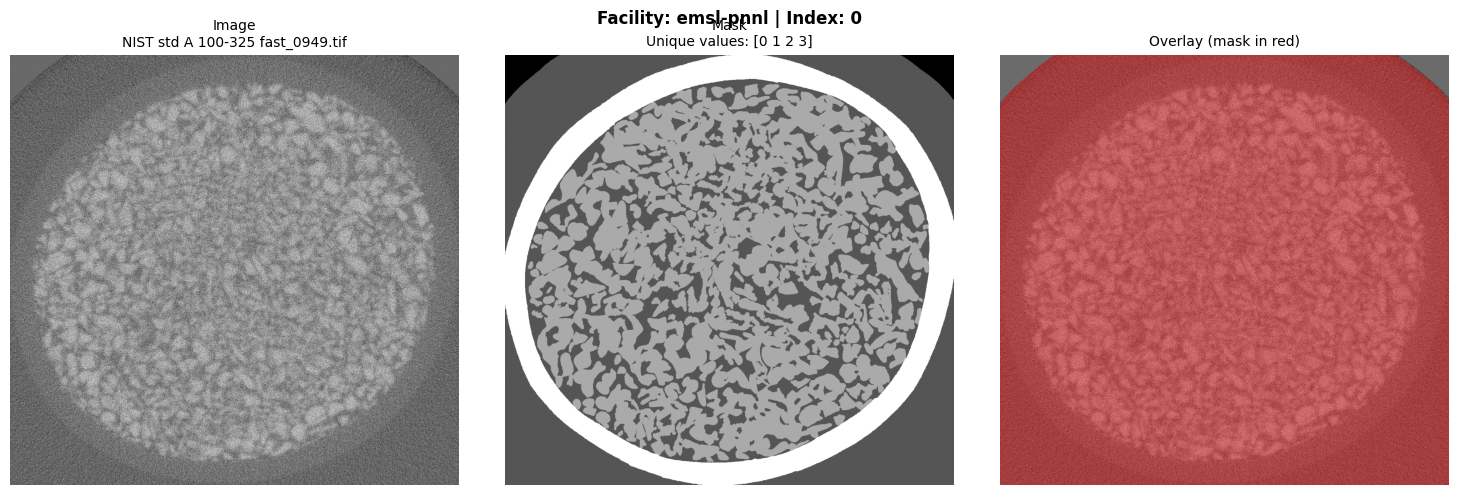


Image Statistics:
  Shape: (1417, 1479)
  Dtype: uint8
  Range: [4, 223]
  Mean: 116.65, Std: 25.44

Mask Statistics:
  Shape: (1417, 1479)
  Dtype: int32
  Unique values: [0 1 2 3]
  Mask coverage: 98.78%

Facility: hex-nsls


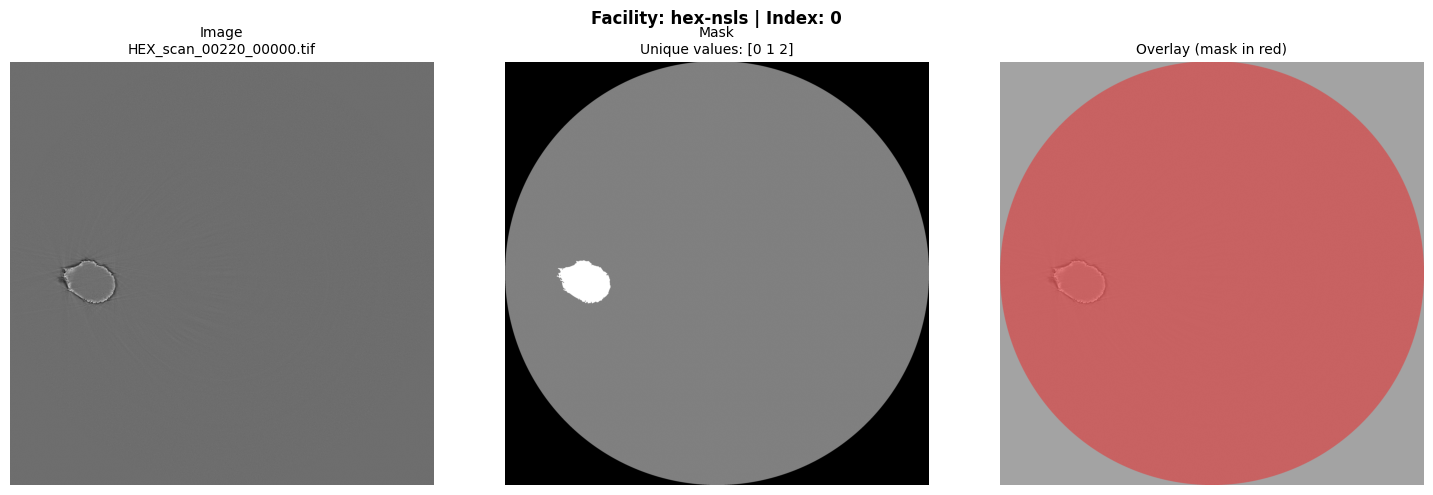


Image Statistics:
  Shape: (3200, 3200)
  Dtype: uint16
  Range: [22239, 60182]
  Mean: 38567.96, Std: 613.97

Mask Statistics:
  Shape: (3200, 3200)
  Dtype: int32
  Unique values: [0 1 2]
  Mask coverage: 78.54%

Facility: microct-als


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.599748158454895..1.0000000059604646].


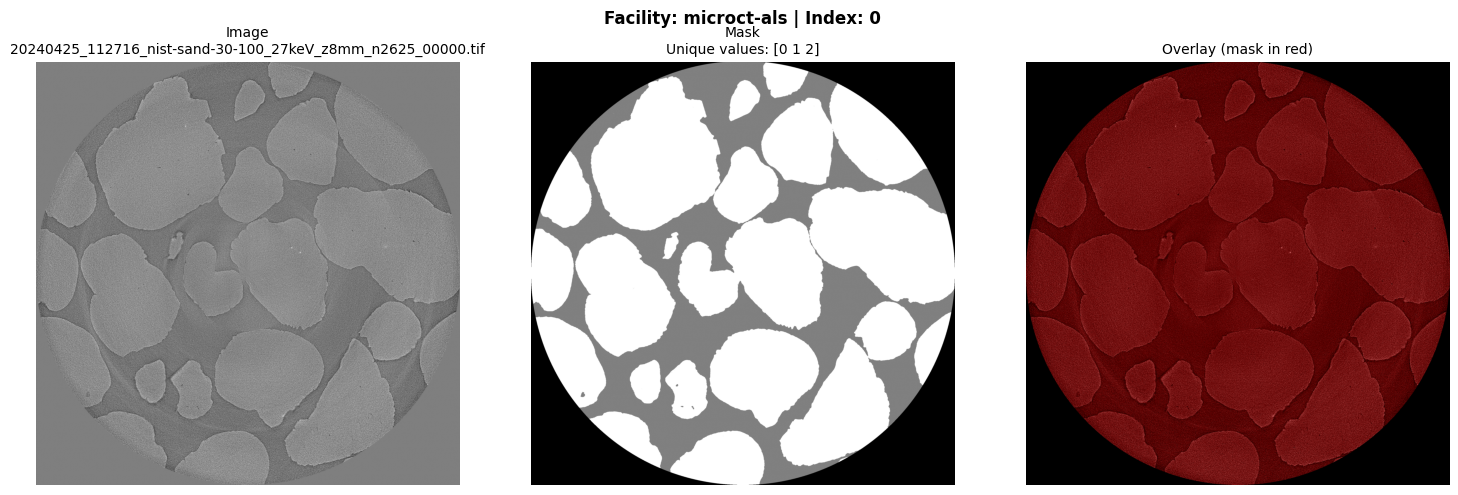


Image Statistics:
  Shape: (2560, 2560)
  Dtype: float32
  Range: [-19.941343307495117, 19.949716567993164]
  Mean: 0.57, Std: 3.08

Mask Statistics:
  Shape: (2560, 2560)
  Dtype: int32
  Unique values: [0 1 2]
  Mask coverage: 78.54%


In [4]:
# Visualize first sample from each facility
for facility in facilities:
    print(f"\n{'='*60}")
    print(f"Facility: {facility}")
    print(f"{'='*60}")
    try:
        visualize_pair(facility, index=0)
    except Exception as e:
        print(f"Error loading {facility}: {e}")

## 4. Interactive Exploration

Use this cell to explore specific facility-index combinations.

Available indices for 2-bm-aps: 0 to 3



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.942217713803984e-05..0.40018151815165764].


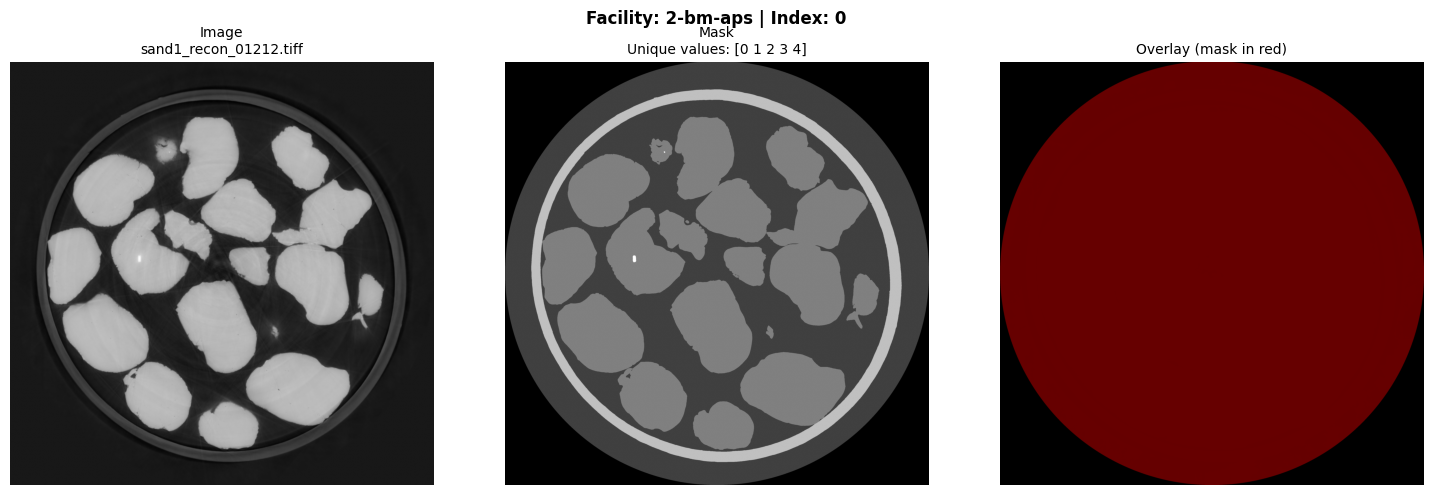


Image Statistics:
  Shape: (3232, 3232)
  Dtype: float32
  Range: [-3.2370295230066404e-05, 0.00030252031865529716]
  Mean: 0.00, Std: 0.00

Mask Statistics:
  Shape: (3232, 3232)
  Dtype: int32
  Unique values: [0 1 2 3 4]
  Mask coverage: 78.54%


In [5]:
# Change these parameters to explore different images
selected_facility = '2-bm-aps'  # Options: '2-bm-aps', 'diad-diomand', 'emsl-pnnl', 'hex-nsls', 'microct-als'
selected_index = 0  # Change to view different images (0 to number of images - 1)

print(f"Available indices for {selected_facility}: 0 to {len(dataset_info[selected_facility]['images']) - 1}")
print()

visualize_pair(selected_facility, selected_index)

## 5. Compare All Facilities Side-by-Side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.942217713803984e-05..0.40018151815165764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0007867035688832402..0.40087281898595395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.599748158454895..1.0000000059604646].


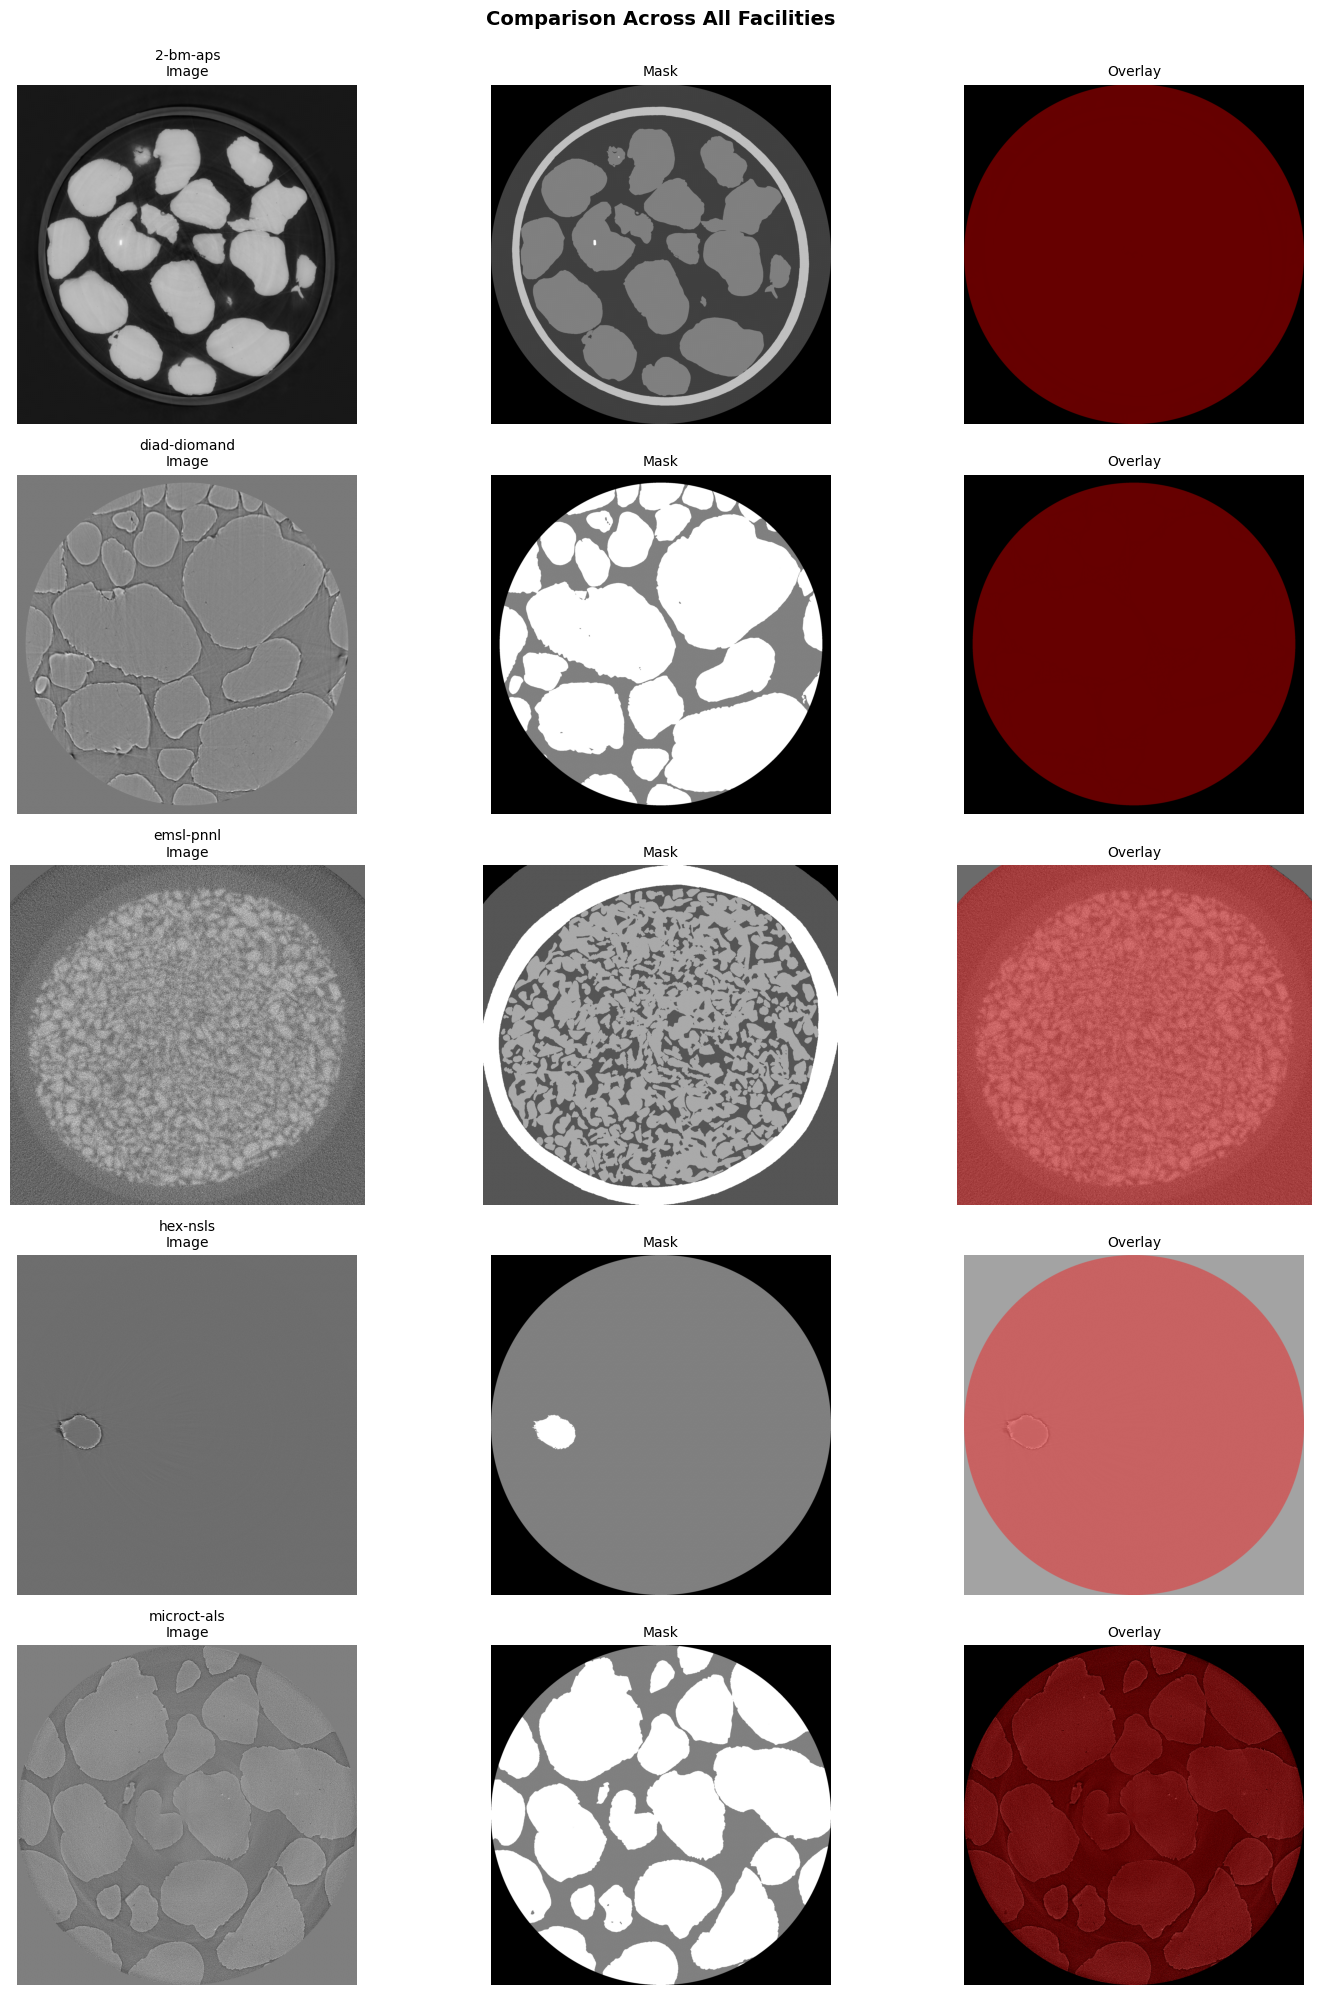

In [6]:
# Create a grid showing first sample from each facility
fig, axes = plt.subplots(len(facilities), 3, figsize=(15, 4*len(facilities)))

for i, facility in enumerate(facilities):
    try:
        image, mask, image_name = load_image_mask_pair(facility, 0)
        
        # Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'{facility}\nImage', fontsize=10)
        axes[i, 0].axis('off')
        
        # Mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask', fontsize=10)
        axes[i, 1].axis('off')
        
        # Overlay
        overlay = image.copy()
        if len(overlay.shape) == 2:
            overlay = np.stack([overlay, overlay, overlay], axis=-1)
        if overlay.max() > 1:
            overlay = overlay / overlay.max()
        
        mask_colored = np.zeros_like(overlay)
        mask_colored[:, :, 0] = mask > 0
        alpha = 0.4
        blended = overlay * (1 - alpha * (mask > 0)[:, :, None]) + mask_colored * alpha
        
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title('Overlay', fontsize=10)
        axes[i, 2].axis('off')
        
    except Exception as e:
        for j in range(3):
            axes[i, j].text(0.5, 0.5, f'Error: {str(e)}', 
                          ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].axis('off')

plt.suptitle('Comparison Across All Facilities', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 6. Dataset Statistics Summary

In [7]:
import pandas as pd

# Collect statistics for all images
stats_data = []

for facility in facilities:
    info = dataset_info[facility]
    
    for idx in range(len(info['images'])):
        try:
            image, mask, image_name = load_image_mask_pair(facility, idx)
            
            stats_data.append({
                'Facility': facility,
                'Image': image_name,
                'Image_Shape': f"{image.shape[0]}x{image.shape[1]}",
                'Image_Dtype': str(image.dtype),
                'Image_Mean': image.mean(),
                'Image_Std': image.std(),
                'Mask_Coverage_%': (mask > 0).sum() / mask.size * 100,
                'Mask_Unique_Values': len(np.unique(mask))
            })
        except Exception as e:
            print(f"Error processing {facility} index {idx}: {e}")

# Create DataFrame
df_stats = pd.DataFrame(stats_data)

print("\nDataset Statistics:")
print("=" * 80)
print(df_stats.to_string(index=False))

print("\n\nSummary by Facility:")
print("=" * 80)
summary = df_stats.groupby('Facility').agg({
    'Image': 'count',
    'Image_Mean': 'mean',
    'Mask_Coverage_%': 'mean'
}).round(2)
summary.columns = ['Count', 'Avg_Image_Mean', 'Avg_Mask_Coverage_%']
print(summary)


Dataset Statistics:
    Facility                                                            Image Image_Shape Image_Dtype   Image_Mean   Image_Std  Mask_Coverage_%  Mask_Unique_Values
    2-bm-aps                                           sand1_recon_01212.tiff   3232x3232     float32     0.000066    0.000089        78.539453                   5
    2-bm-aps                                            sand2_recon_01212.tif   3232x3232     float32     0.000074    0.000086        78.539453                   4
    2-bm-aps                                           sand3_recon_01212.tiff   3232x3232     float32     0.000016    0.000044        78.539414                   4
    2-bm-aps                                           sand4_recon_01212.tiff   3232x3232     float32     0.000070    0.000087        78.539443                   5
diad-diomand                     Savu_k11-38727_full_fd_vo_AST_tiff_00000.tif   2560x2560     float32     0.000081    0.000155        70.772766                

## 7. Export Sample Images (Optional)

In [8]:
# Uncomment and run this cell to save visualization examples

# output_dir = './visualization_examples'
# os.makedirs(output_dir, exist_ok=True)

# for facility in facilities:
#     try:
#         image, mask, image_name = load_image_mask_pair(facility, 0)
#         
#         # Save as PNG for easy viewing
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         
#         axes[0].imshow(image, cmap='gray')
#         axes[0].set_title('Image')
#         axes[0].axis('off')
#         
#         axes[1].imshow(mask, cmap='gray')
#         axes[1].set_title('Mask')
#         axes[1].axis('off')
#         
#         overlay = image.copy()
#         if len(overlay.shape) == 2:
#             overlay = np.stack([overlay, overlay, overlay], axis=-1)
#         if overlay.max() > 1:
#             overlay = overlay / overlay.max()
#         mask_colored = np.zeros_like(overlay)
#         mask_colored[:, :, 0] = mask > 0
#         blended = overlay * 0.6 + mask_colored * 0.4
#         
#         axes[2].imshow(blended)
#         axes[2].set_title('Overlay')
#         axes[2].axis('off')
#         
#         plt.suptitle(f'{facility}', fontsize=12)
#         plt.tight_layout()
#         
#         output_path = os.path.join(output_dir, f'{facility}_sample.png')
#         plt.savefig(output_path, dpi=150, bbox_inches='tight')
#         plt.close()
#         
#         print(f"Saved: {output_path}")
#     except Exception as e:
#         print(f"Error saving {facility}: {e}")

# print(f"\nVisualization examples saved to: {output_dir}")